## HW2 - 2 LP sourcing formulations and LP Duals

In this second homework assignment we will focus on a few more LP formulations as well as a duality question.

In [2]:
import gurobipy as gp
from IPython.display import Image

#### Problem 1: Product mix and profit maximization

A canning company operates two plants (South and Central). Its suppliers provide fresh fruit of three different kinds (peaches, pears, and pineapples). The unit cost of peaches, pears, and pineapples is 110, 100, and 90 USD respectively. The shipping costs per unit are (respectively, for peaches, pears, and pineapples) 30, 20, and 60 USD to the southern plant. To the central plant, the shipping costs are 35, 25, and 40 USD. The southern plant has a capacity of 460 units, and labor costs of 260 USD per unit. The central plant has a capacity of 560 units, and labor costs of 210 USD per unit. Labor costs at both plants are independent of fruit type.

Cans of peaches, pears, and pineapples are sold to distributors at 480, 500, and 520 USD per unit respectively. The distributors provide (and pay for) the shipping from the plants.

Assuming that the company wants to maximize its profit, how much of each fruit should they can at each of the factories? 

- What decision variables would you use to find the optimal shipments?

.The decision variables would be the number of units for different types of fruits at the two different plants. This would result in 6 decision variables: units of peaches to central, units of pears to central, units of pineapples to central, units of peaches to south, units of pears to south, and units of pineapples to south.

- How would you encode the objective of this LP?



. The objective would be to maximize profit which is revenue minus labor cost of all units, cost of shipments for all units, and purchase cost of all units. 

The optimization objective would be written as below. Plant 0 is the South Plant and Plant 1 is the Central Plant. Units are the decision variables stored in a dictionary with the key as a tuple. The price of the fruit and cost of shipment for the fruits are stored as a dictionary with the fruit as the key and the plants' respective costs/price stored in a list; position 0 corresponds with the South Plant and position 1 corresponds with the Central Plant.

m.setObjective(sum(units[(plant,fruit)]*sold_price[fruit] for fruit in sold_price for plant in range(2)) -
               sum(units[(plant,fruit)]*purchase_cost[fruit] for fruit in sold_price for plant in range(2)) -
               sum(units[(plant,fruit)]*ship_cost[fruit][plant] for fruit in sold_price for plant in range(2)) - 
               sum(units[(0,fruit)] for fruit in sold_price)*260 - sum(units[(1,fruit)] for fruit in sold_price)*210 ,                        gp.GRB.MAXIMIZE)


- What kind of constraints will a LP require to solve this question? First describe the effect each constraint would have in English, then write them out (notice that Jupyter should understand latex, so you can either write them out in mathematical form or write out a description like "sum over all variables of this type be at most that" --- in the latter case, make sure to be as precise as possible!)

.There are two constraints; one for each of the plant's capacity. The first constraint is the sum of all the decision variables associated with the South Plant must be less than or equal to 460. The second constraint is the sum of all the decision variables associated with the Central Plant must be less than or equal to 560.

$$\sum_{fruit=peaches,pears,pineapples} fruit\_shipped\_to\_south <= 460$$
$$\sum_{fruit=peaches,pears,pineapples} fruit\_shipped\_to\_central <= 560$$


Bonus: implement the above in gurobi (not required, but if you struggled with HW1 it would be good practice to write it out from scratch!).

In [19]:
# Define price fruits are sold for
sold_price = {'peach': 480, 'pear': 500, 'pineapple': 520}

# Define price fruits are sold for
purchase_cost = {'peach': 110, 'pear': 100, 'pineapple': 90}

# The dictionary below holds the cost of shipping of each fruit to the two plants.
# The cost in position 0 corresponds with Plant South and the cost in position1 corresponds with Plant Central.
ship_cost = {'peach': [30,35],'pear': [20, 25],'pineapple': [60, 40]}
# e.g., the cost of one shipment of peach to Plant South is $30/unit.

# Define max capacity for the two plants. Position 0 is South Plant and Position 1 is Central Plant.
capacity = [460,560]

m = gp.Model("fruits")
units = {}

# Define decision variables to indicate for each supplier/center how much is shipped
for fruit in sold_price:
    for plant in range(2):
        units[(plant,fruit)] = m.addVar(name=str((plant,fruit)))
        
# Next, we set our objective: maximize profit 
m.setObjective(sum(units[(plant,fruit)]*sold_price[fruit] for fruit in sold_price for plant in range(2)) -
               sum(units[(plant,fruit)]*purchase_cost[fruit] for fruit in sold_price for plant in range(2)) -
               sum(units[(plant,fruit)]*ship_cost[fruit][plant] for fruit in sold_price for plant in range(2)) - 
               sum(units[(0,fruit)] for fruit in sold_price)*260 - sum(units[(1,fruit)] for fruit in sold_price)*210 , gp.GRB.MAXIMIZE)

# Set a constraint that we cannot exceen the capacity of the plant.
for plant in range(2):
    m.addConstr(sum(units[(plant,fruit)] for fruit in sold_price) <= capacity[plant])
    

m.optimize()

for plant in range(2):
    for fruit in sold_price:
        print(units[plant,fruit])

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 2 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x2394998a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 6e+02]
Presolve removed 2 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5600000e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.560000000e+05
<gurobi.Var (0, 'peach') (value 0.0)>
<gurobi.Var (0, 'pear') (value 460.0)>
<gurobi.Var (0, 'pineapple') (value 0.0)>
<gurobi.Var (1, 'peach') (value 0.0)>
<gurobi.Var (1, 'pear') (value 0.0)>
<gurobi.Var (1, 'pineapple') (value 560.0)>


#### Problem 2: Taking a dual

In class we discussed how to take the dual LP of a given primal LP. In this problem, we will practice taking duals, and remind ourselves both of how the dual solution relates to sensitivity analysis and of how gurobi can give us the dual solutions.

The primal problem we study is as follows:


$\max x + 3\cdot y + 2\cdot z$

subject to:

$ 0\leq x \leq 10$

$0 \leq y \leq 12$

$3\cdot x+y+5\cdot z\leq 10 $

$x + 3\cdot y\leq 12$

$3\cdot z\geq 6$


Below, I already implemented this LP in Gurobi. Make sure you follow all the steps.

In [11]:
# First, we define a variable that contains the optimization model
m = gp.Model("primal")

# Next, we define the three decision variables with their respective lower and upper bounds
x = m.addVar(lb = 0) # 0<= x
y = m.addVar(lb = 0) # 0<= y
z = m.addVar(lb=-gp.GRB.INFINITY) # z can be anything

# Then, we give bounds on x and y being at most 10, respectively 12
bound_x = m.addConstr(x<=10) 
bound_y = m.addConstr(y<=12) 

# Then, we add the other constraints
c1 = m.addConstr(3*x+y+5*z<=10) # 3x + y + 5z<=10
c2 = m.addConstr(x+3*y<=12) # x + 3y<=12
c3 = m.addConstr(3*z>=6) # 3*z>=6

# Next, we set our objective: maximizing x+3y+2z
m.setObjective(x+3*y+2*z, gp.GRB.MAXIMIZE)

m.optimize()

# Then we print the solution values for each variable
print(x.x,y.x,z.x)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5 rows, 3 columns and 8 nonzeros
Model fingerprint: 0x512860b2
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Presolve removed 5 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.000000000e+00
0.0 0.0 2.0


- Write the LP in standard form (probably easiest to copy-paste from the markdown cell above, and then make changes where necessary)

$3\cdot x+y+5\cdot z\leq 10 $

$x + 3\cdot y\leq 12$

$-3\cdot z\leq -6$

$x \leq 10$

$y \leq 12$

$x \geq 0$

$y \geq 0$

- On paper (no need to submit), write out the dual of this LP

$\min 10\cdot A + 12\cdot B - 6\cdot C + 10\cdot D +12\cdot E$

subject to:

$3\cdot A + B + D\geq 1 $

$A + 3\cdot B + E\geq 3$

$5\cdot A - 3\cdot C\geq 2$

- Implement dual of the LP in gurobi, solve it, and verify that strong duality holds, i.e., that the optimal solutions of primal and dual match.

In [9]:
# First, we define a variable that contains the optimization model
m = gp.Model("dual")

# Next, we define the three decision variables with their respective lower and upper bounds
A = m.addVar(lb = 0) # 0<= A
B = m.addVar(lb = 0) # 0<= B
C = m.addVar(lb = 0) # 0<= C
D = m.addVar(lb = 0) # 0<= D
E = m.addVar(lb = 0) # 0<= E



# Then, we add the other constraints
x = m.addConstr(3*A + B + D >= 1) # 3x + y + 5z<=10
y = m.addConstr(A + 3*B + E >= 3) # x + 3y<=12
z = m.addConstr(5*A - 3*C >= 2) # 3*z>=6

# Next, we set our objective: maximizing x+3y+2z
m.setObjective(10*A + 12*B -6*C + 10*D + 12*E, gp.GRB.MINIMIZE)

m.optimize()

# Then we print the solution values for each variable
print(A.x,B.x,C.x,D.x,E.x)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 3 rows, 5 columns and 8 nonzeros
Model fingerprint: 0xfe6b1159
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [6e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 3 rows and 5 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.000000000e+00
3.0 0.0 4.333333333333333 0.0 0.0


- In class we discussed the idea of shadow prices and sensitivity analysis. In Gurobi, as we saw in class, we can find the dual variable of a constraint c by typing c.pi, so for example:

In [12]:
c1.pi

3.0

Can you give a shadow price explanation of what c1.pi being equal to 3 means? Write out, and solve, a new LP (in Gurobi) that illustrates the shadow price of c1 being 3. Do the same for one of the other constraints (c2 or c3), and explain your findings.

In [13]:
# NEW MODEL EXPLAINING SHADOW PRICE FOR C1 = 3
m = gp.Model("primal")

# Next, we define the three decision variables with their respective lower and upper bounds
x = m.addVar(lb = 0) # 0<= x
y = m.addVar(lb = 0) # 0<= y
z = m.addVar(lb=-gp.GRB.INFINITY) # z can be anything

# Then, we give bounds on x and y being at most 10, respectively 12
bound_x = m.addConstr(x<=10) 
bound_y = m.addConstr(y<=12) 

# Then, we add the other constraints
c1 = m.addConstr(3*x+y+5*z<=11) # 3x + y + 5z<=11, increased upper bound by 1 from base case based on shadow price
c2 = m.addConstr(x+3*y<=12) # x + 3y<=12
c3 = m.addConstr(3*z>=6) # 3*z>=6

# Next, we set our objective: maximizing x+3y+2z
m.setObjective(x+3*y+2*z, gp.GRB.MAXIMIZE)

m.optimize()

# Then we print the solution values for each variable
print(x.x + 3*y.x + 2*z.x)

############################################################

# NEW MODEL EXPLAINING SHADOW PRICE FOR C3 = -4.333
m = gp.Model("primal")

# Next, we define the three decision variables with their respective lower and upper bounds
x = m.addVar(lb = 0) # 0<= x
y = m.addVar(lb = 0) # 0<= y
z = m.addVar(lb=-gp.GRB.INFINITY) # z can be anything

# Then, we give bounds on x and y being at most 10, respectively 12
bound_x = m.addConstr(x<=10) 
bound_y = m.addConstr(y<=12) 

# Then, we add the other constraints
c1 = m.addConstr(3*x+y+5*z<=10) # 3x + y + 5z<=10
c2 = m.addConstr(x+3*y<=12) # x + 3y<=12
c3 = m.addConstr(3*z>=5) # 3*z>=5, decreased upper bound by 1 from base case based on shadow price

# Next, we set our objective: maximizing x+3y+2z
m.setObjective(x+3*y+2*z, gp.GRB.MAXIMIZE)

m.optimize()

# Then we print the solution values for each variable
print(x.x + 3*y.x + 2*z.x)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5 rows, 3 columns and 8 nonzeros
Model fingerprint: 0xbeef9b92
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Presolve removed 5 rows and 3 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.000000000e+00
7.0
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5 rows, 3 columns and 8 nonzeros
Model fingerprint: 0x3267d07a
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+01]
Presolve removed 5 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns remo

Findings explained:

c1.pi equals 3 means if we increase the upper bound of c1 by 1, we'll increase the optimal solution by 3. Likewise, c3.pi equals negative 4.33; therefore, if we decrease the upper bound of c3 by 1, we'll increase the optimal solution be 4.33.

In the code executed above, the base optimal solution was 4. By increasing the upper bound of c1 by one, the new optimal solution is 7. By decreasing the upper bound of c3 by one, the new optimal solution is 8.33.


#### Problem 3: Minimize transportation costs

Consider the following supply network where the number on each arc indicates the per-unit cost of shipping from one location to another. The supply at the factories is the number of units each factory can provide, the demand next to customers indicate how many units are needed.

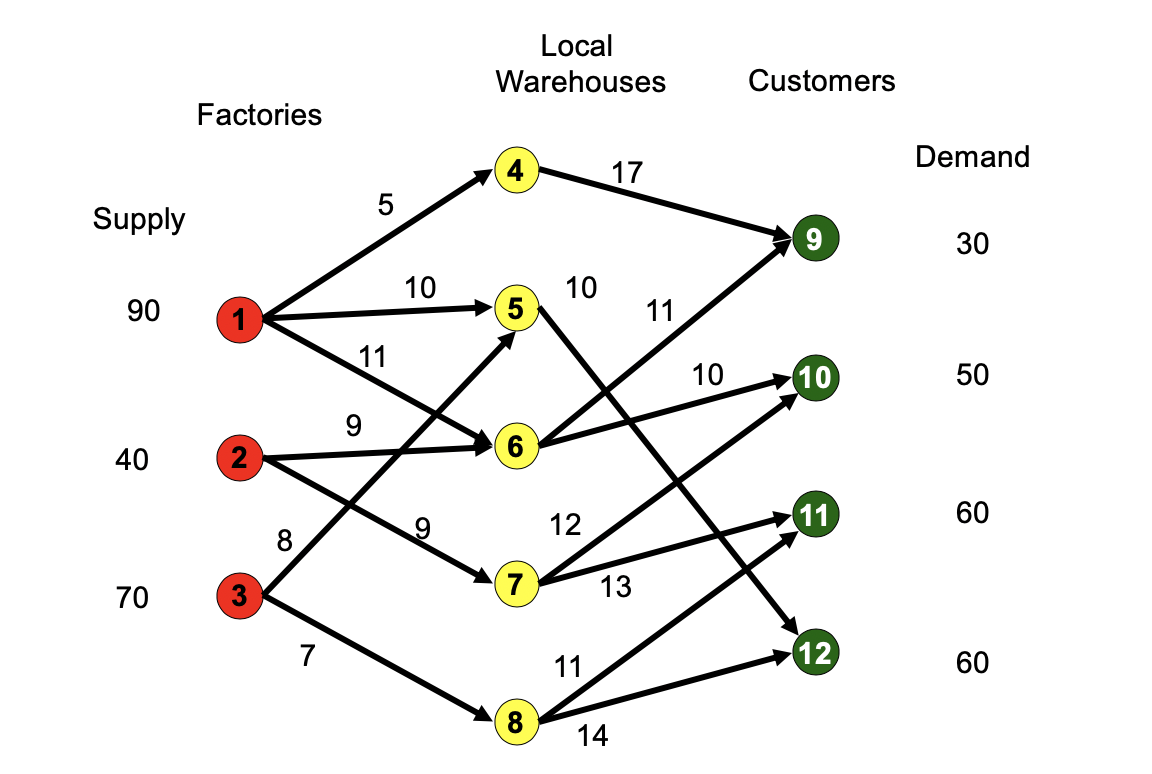

In [4]:
# DO NOT RUN THIS CELL, ELSE YOU'LL LOSE THE PICTURE OF THE NETWORK!
Image("warehouse_network.png")

Our goal here is to satisfy all the demand while respecting the supply constraints at the factories, and minimizing the total cost of shipping.

- What decision variables would you use to find the optimal shipments

.The decision variables will be number of units sent along each arc. In the scenario above, there would be 15 decision variables - 7 for shipments from factories to warehouses (X1,4 , X1,4 , X1,6 , X2,6 , X2,7 , X3,5 , X3,8) and 8 from warehouses to customers (X4,9 , X5,12 , X6,9 , X6,10 , X7,10 , X7,11 , X8,11 , X8,12).

- How would you encode the objective of this LP?

.The objective function of the LP would be to minimize the shipping cost from the factories to the customers. The shipping cost can be represented by the sum of the number of units multiplied by their respective shipping cost for their arc between factories and warehouses and the sum of the number of units multiplied by their respective shipping cost for their arc between warehouses and customers.

- What kind of constraints will a LP require to solve this question? First describe the effect each constraint would have in English, then write them out.

.The constraints would be: 
1. the factories cannot ship more than their supply limit 
2. the customer needs to receive needs to receive the exact demand.
3. the shipments into the warehouses must equal the shipments out of the warehosues.

FACTORY SUPPLY CONSTRAINTS

$X1,4 + X1,5 + X1,6 \leq 90 $

$X2,6 + X2,7 \leq 40 $

$X3,5 + X3,8 \leq 70 $


CUSTOMER DEMAND CONSTRAINTS

$X4,9 + X6,9 = 30 $

$X6,10 + X7,10 = 50 $

$X7,11 + X8,11 = 60 $

$X5,12 + X8,12 = 60 $


WAREHOUSES SHIPMENT BALANCE

$X1,4 - X4,9 = 0 $

$(X1,5 + X3,5) - X5,12 = 0 $

$(X1,6 + X2,6) - (X6,9 + X6,10) = 0 $

$X2,7 - (X7,10 + X7,11) = 0 $

$X3,8 - (X8,11 + X8,12) = 0 $

- Solve the problem in Gurobi. Make sure to save all the constraints you use (in dictionaries or as variablees), so you can later access them. 

In [25]:
m = gp.Model("shipments")

units = {}

# Next, we define the decision variables for shipments between factories and warehouses
units[(1,4)] = m.addVar(name=str((1,4)))
units[(1,5)] = m.addVar(name=str((1,5)))
units[(1,6)] = m.addVar(name=str((1,6)))
units[(2,6)] = m.addVar(name=str((2,6)))
units[(2,7)] = m.addVar(name=str((2,7)))
units[(3,5)] = m.addVar(name=str((3,5)))
units[(3,8)] = m.addVar(name=str((3,8)))

# Next, we define the decision variables for shipments between warehouses and customers
units[(4,9)] = m.addVar(name=str((4,9)))
units[(5,12)] = m.addVar(name=str((5,12)))
units[(6,9)] = m.addVar(name=str((6,9)))
units[(6,10)] = m.addVar(name=str((6,10)))
units[(7,10)] = m.addVar(name=str((7,10)))
units[(7,11)] = m.addVar(name=str((7,11)))
units[(8,11)] = m.addVar(name=str((8,11)))
units[(8,12)] = m.addVar(name=str((8,12)))

# define shipment costs.
shipment = {}
shipment[(1,4)] = 5
shipment[(1,5)] = 10
shipment[(1,6)] = 11
shipment[(2,6)] = 9
shipment[(2,7)] = 9
shipment[(3,5)] = 8
shipment[(3,8)] = 7
shipment[(4,9)] = 17
shipment[(5,12)] = 10
shipment[(6,9)] = 11
shipment[(6,10)] = 10
shipment[(7,10)] = 12
shipment[(7,11)] = 13
shipment[(8,11)] = 11
shipment[(8,12)] = 14


# Then, we add the factory supply constraints
F1 = m.addConstr(units[(1,4)] + units[(1,5)] + units[(1,6)] <= 90)
F2 = m.addConstr(units[(2,6)] + units[(2,7)] <= 40)
F3 = m.addConstr(units[(3,5)] + units[(3,8)] <= 70)

# Then, we add the customer demand constraints
C9 = m.addConstr(units[(4,9)] + units[(6,9)] == 30)
C10 = m.addConstr(units[(6,10)] + units[(7,10)] == 50)
C11 = m.addConstr(units[(7,11)] + units[(8,11)] == 60)
C12 = m.addConstr(units[(5,12)] + units[(8,12)] == 60)
    
# Then, we add warehouse balance constraints
W4 = m.addConstr(units[(1,4)] - units[(4,9)] == 0)
W5 = m.addConstr((units[(1,5)] + units[(3,5)]) - units[(5,12)] == 0)
W6 = m.addConstr((units[(1,6)] + units[(2,6)]) - (units[(6,9)] + units[(6,10)]) == 0)
W7 = m.addConstr(units[(2,7)] - (units[(7,10)] + units[(7,11)]) == 0)
W8 = m.addConstr(units[(3,8)] - (units[(8,11)] + units[(8,12)]) == 0)

# Next, we set our objective: maximizing x+3y+2z
m.setObjective(sum(units[(arc)]*shipment[(arc)] for arc in units), gp.GRB.MINIMIZE)

m.optimize()

for arc in units:
    print(units[arc])

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 12 rows, 15 columns and 30 nonzeros
Model fingerprint: 0x60821db9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 9e+01]
Presolve removed 7 rows and 10 columns
Presolve time: 0.02s
Presolved: 5 rows, 5 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8098960e+03   5.006500e+00   0.000000e+00      0s
       2    3.8900000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds
Optimal objective  3.890000000e+03
<gurobi.Var (1, 4) (value 0.0)>
<gurobi.Var (1, 5) (value 50.0)>
<gurobi.Var (1, 6) (value 40.0)>
<gurobi.Var (2, 6) (value 40.0)>
<gurobi.Var (2, 7) (value 0.0)>
<gurobi.Var (3, 5) (value 10.0)>
<gurobi.Var (3, 8) (value 60.0)>
<gurobi.Var (4, 9) (value 0.0)>
<gurobi.Var (5, 12) (value 60.0)>
<gurobi.Var (6, 9) (value 30.0)

- Your LP should have a constraint limiting the amount of supply coming out of factory 2. Query gurobi for the shadow price of that constraint. Then, rerun the optimization with that constraint somewhat relaxed, and give an intuitive economic explanation for the value of the shadow price (i.e., explain the value, in shipping costs, of increasing the capacity of factory 2), as well as how that value is created.

In [5]:
F2.pi

-2.0

- The constraint of F2 (factory 2) is that the supply must be less than or equal to 40. The shadow price of -2.0  means that if we increase the supply from F2 to be less than or equal to 41, we'd expect the optimial solution for our shipment costs to decrease by 2.

- From an economic perspective, factory 2 can only ship to warehouse 6 and 7. Warehouse 7 can only receive shipments from factory 2, so the supply increase from 40 to 41 for factory 2 doesn't do anythign in this scenario. Warehouse 6 can also receive shipments from factory 1; however, the cost from factor 1 is 11 per unit while the cost from factory 2 is 9. Consequently, the LP will optimize to remove one shipment from factor 1 to warehosue 6 and increase one shipment from factor 2 to warehouse 6. This difference is shipment cost is 2 which is why the optimal solution decreases by 2. This can be seen when the model is rerun below.

In [23]:
# First, we define a variable that contains the optimization model
m = gp.Model("shipments")

units = {}

# Next, we define the decision variables for shipments between factories and warehouses
units[(1,4)] = m.addVar(name=str((1,4)))
units[(1,5)] = m.addVar(name=str((1,5)))
units[(1,6)] = m.addVar(name=str((1,6)))
units[(2,6)] = m.addVar(name=str((2,6)))
units[(2,7)] = m.addVar(name=str((2,7)))
units[(3,5)] = m.addVar(name=str((3,5)))
units[(3,8)] = m.addVar(name=str((3,8)))

# Next, we define the decision variables for shipments between warehouses and customers
units[(4,9)] = m.addVar(name=str((4,9)))
units[(5,12)] = m.addVar(name=str((5,12)))
units[(6,9)] = m.addVar(name=str((6,9)))
units[(6,10)] = m.addVar(name=str((6,10)))
units[(7,10)] = m.addVar(name=str((7,10)))
units[(7,11)] = m.addVar(name=str((7,11)))
units[(8,11)] = m.addVar(name=str((8,11)))
units[(8,12)] = m.addVar(name=str((8,12)))

# define shipment costs.
shipment = {}
shipment[(1,4)] = 5
shipment[(1,5)] = 10
shipment[(1,6)] = 11
shipment[(2,6)] = 9
shipment[(2,7)] = 9
shipment[(3,5)] = 8
shipment[(3,8)] = 7
shipment[(4,9)] = 17
shipment[(5,12)] = 10
shipment[(6,9)] = 11
shipment[(6,10)] = 10
shipment[(7,10)] = 12
shipment[(7,11)] = 13
shipment[(8,11)] = 11
shipment[(8,12)] = 14


# Then, we add the factory supply constraints
F1 = m.addConstr(units[(1,4)] + units[(1,5)] + units[(1,6)] <= 90)
F2 = m.addConstr(units[(2,6)] + units[(2,7)] <= 41)
F3 = m.addConstr(units[(3,5)] + units[(3,8)] <= 70)

# Then, we add the customer demand constraints
C9 = m.addConstr(units[(4,9)] + units[(6,9)] == 30)
C10 = m.addConstr(units[(6,10)] + units[(7,10)] == 50)
C11 = m.addConstr(units[(7,11)] + units[(8,11)] == 60)
C12 = m.addConstr(units[(5,12)] + units[(8,12)] == 60)
    
# Then, we add warehouse balance constraints
W4 = m.addConstr(units[(1,4)] - units[(4,9)] == 0)
W5 = m.addConstr((units[(1,5)] + units[(3,5)]) - units[(5,12)] == 0)
W6 = m.addConstr((units[(1,6)] + units[(2,6)]) - (units[(6,9)] + units[(6,10)]) == 0)
W7 = m.addConstr(units[(2,7)] - (units[(7,10)] + units[(7,11)]) == 0)
W8 = m.addConstr(units[(3,8)] - (units[(8,11)] + units[(8,12)]) == 0)

# Next, we set our objective: maximizing x+3y+2z
m.setObjective(sum(units[(arc)]*shipment[(arc)] for arc in units), gp.GRB.MINIMIZE)

m.optimize()

for arc in units:
    print(units[arc])

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 12 rows, 15 columns and 30 nonzeros
Model fingerprint: 0xef8d4619
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 9e+01]
Presolve removed 7 rows and 10 columns
Presolve time: 0.00s
Presolved: 5 rows, 5 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8059000e+03   5.131250e+00   0.000000e+00      0s
       2    3.8880000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.888000000e+03
<gurobi.Var (1, 4) (value 0.0)>
<gurobi.Var (1, 5) (value 50.0)>
<gurobi.Var (1, 6) (value 39.0)>
<gurobi.Var (2, 6) (value 41.0)>
<gurobi.Var (2, 7) (value 0.0)>
<gurobi.Var (3, 5) (value 10.0)>
<gurobi.Var (3, 8) (value 60.0)>
<gurobi.Var (4, 9) (value 0.0)>
<gurobi.Var (5, 12) (value 60.0)>
<gurobi.Var (6, 9) (value 30.0)

- Your LP should have, for each warehouse, a constraint that enforces that the amount of inventory in the warehouse is non-negative at the end of the optimization. Query the dual variable of that constraint, and explain its value.

In [26]:
print(W4.pi, W5.pi, W6.pi, W7.pi, W8.pi)

5.0 10.0 11.0 11.0 9.0


- The current LP has a non-negative constraints for the net inventory (inventory in - inventory out) within a warehouse. The dual variables shown above for the respective warehouse indicates that if we increase the warehouse balance constraint by 1, we will increase the optimial shipping cost by the respective dual value. 
- Intuitively, this makes sense because by increasing the warehouse balance constraint by one, we are forcing the LP to have one additional unit left in the warehouse. This means we'll add additional shipping cost from the factory to the warehouse for one unit without being able ship that unit to the customers.